In [0]:
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_007320.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_007860.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03090.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03510_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08015_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06030_P.png')]

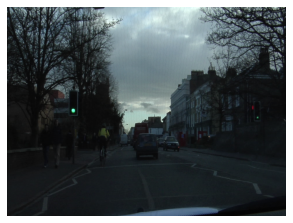

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [0]:
# testing the get_y_fn function now
# its meant to get the path of the label image corresponding to an image 

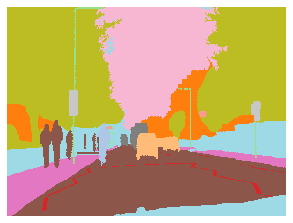

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size=np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [0]:
# 720 x 960 image. with every bit represented by a number corresponding to a label

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); 
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
size = src_size //2
free= gpu_mem_get_free_no_cache()
print(free)

16270


In [0]:
bs=8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes= codes))

In [0]:
data = (src.transform(get_transforms(),size=size,tfm_y = True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

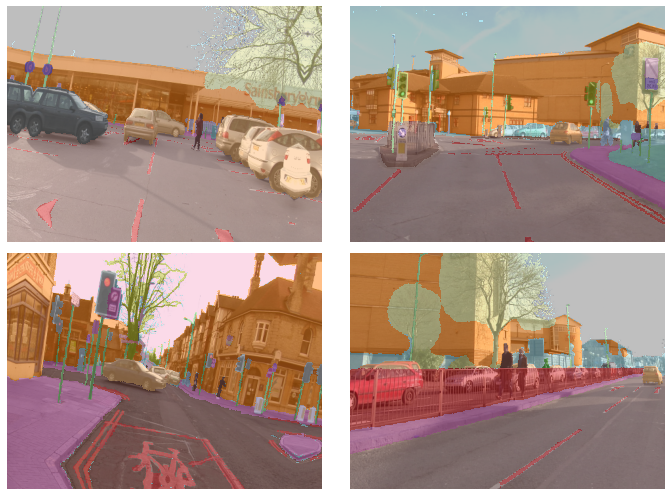

In [19]:
data.show_batch(2,figsize=(10,7))

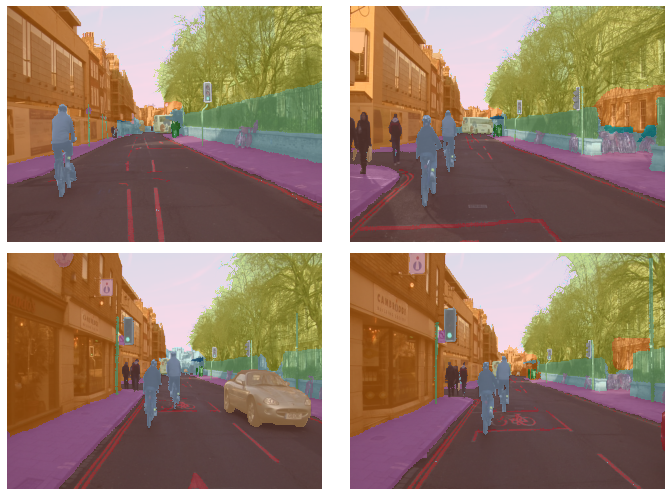

In [20]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
# now training the model

In [0]:
# for measuring the accuracy, we are given a function, copying that code

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd=1e-2

In [0]:
# training a U-net

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


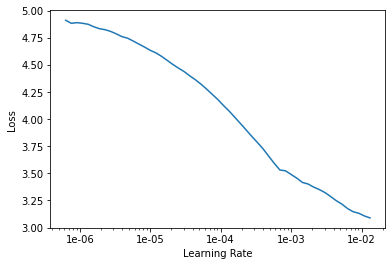

In [30]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [32]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.447376,0.940864,0.793545,00:55
1,0.935721,0.676576,0.835033,00:52
2,0.734268,0.677034,0.822281,00:52
3,0.672157,0.601777,0.848217,00:52
4,0.642663,0.515798,0.854068,00:52
5,0.589503,0.492606,0.862269,00:51
6,1.463819,1.420412,0.659273,00:51
7,1.092719,0.691284,0.842053,00:52
8,0.753226,0.476472,0.869901,00:52
9,0.568916,0.445883,0.876512,00:52


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

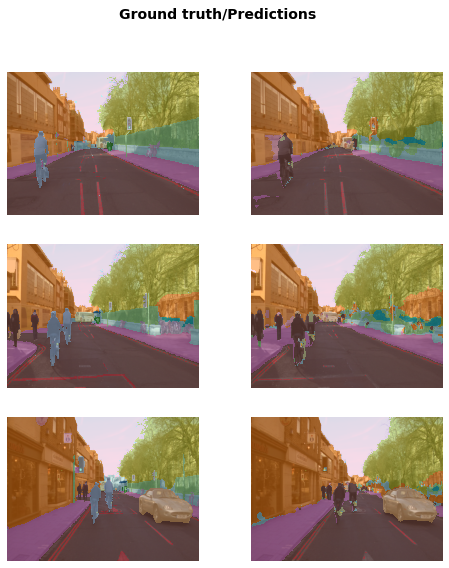

In [37]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [40]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.474511,0.421874,0.881753,00:53
1,0.470213,0.404415,0.884120,00:53
2,0.458269,0.377986,0.890494,00:52
3,0.438588,0.369376,0.894855,00:52
4,0.422928,0.355009,0.898185,00:52
5,0.408876,0.335585,0.902386,00:52
6,0.384910,0.314311,0.915723,00:52
7,0.369289,0.331636,0.907452,00:52
8,0.346279,0.307456,0.913356,00:52
9,0.334298,0.314689,0.910648,00:52


In [0]:
learn.save('stage-2')